#  Lab | Making predictions with logistic regression

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [87]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass
password = getpass.getpass()

········


In [88]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

query = 'select inventory.film_id, category.name as category_name, count(inventory.inventory_id) as number_of_copy, film.rental_rate, film.length, film.rental_duration, count(rental.rental_id) as number_rental  \
from rental, inventory, film, film_category, category  \
where inventory.inventory_id=rental.inventory_id  \
and film.film_id=inventory.film_id  \
and film.film_id=film_category.film_id  \
and film_category.category_id=category.category_id \
group by inventory.film_id, category.name  \
order by inventory.film_id asc'

2. Read the data into a Pandas dataframe.

In [89]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,category_name,number_of_copy,rental_rate,length,rental_duration,number_rental
0,1,Documentary,24,0.99,86,6,24
1,2,Horror,7,4.99,48,3,7
2,3,Documentary,12,2.99,50,7,12
3,4,Horror,23,2.99,117,5,23
4,5,Family,12,2.99,130,6,12


In [90]:
data

,film_id,category_name,number_of_copy,rental_rate,length,rental_duration,number_rental
0,1,Documentary,24,0.99,86,6,24
1,2,Horror,7,4.99,48,3,7
2,3,Documentary,12,2.99,50,7,12
3,4,Horror,23,2.99,117,5,23
4,5,Family,12,2.99,130,6,12
...,...,...,...,...,...,...,...
953,996,Documentary,7,0.99,183,6,7
954,997,Music,6,0.99,179,4,6
955,998,Horror,9,0.99,105,6,9
956,999,Children,17,2.99,101,5,17


3. Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [92]:
# Getting the possible values of the category name
data['category_name'].value_counts()

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Drama          61
Action         61
New            60
Sci-Fi         59
Children       58
Games          58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category_name, dtype: int64

In [93]:
# Data shape
data.shape

(958, 7)

In [94]:
# Data types
data.dtypes

film_id              int64
category_name       object
number_of_copy       int64
rental_rate        float64
length               int64
rental_duration      int64
number_rental        int64
dtype: object

In [95]:
# Checking NAs
data.isna().sum()

film_id            0
category_name      0
number_of_copy     0
rental_rate        0
length             0
rental_duration    0
number_rental      0
dtype: int64

In [96]:
data['film_id'] = data['film_id'].astype('str')
data['category_name'] = data['category_name'].astype('str')

In [97]:
data.describe()

,number_of_copy,rental_rate,length,rental_duration,number_rental
count,958.000000,958.000000,958.000000,958.000000,958.000000
mean,16.748434,2.977474,115.490605,4.969729,16.748434
std,6.677241,1.643152,40.471844,1.407593,6.677241
min,4.000000,0.990000,46.000000,3.000000,4.000000
25%,11.000000,0.990000,80.250000,4.000000,11.000000
50%,16.000000,2.990000,114.000000,5.000000,16.000000
75%,22.000000,4.990000,150.000000,6.000000,22.000000
max,34.000000,4.990000,185.000000,7.000000,34.000000


In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

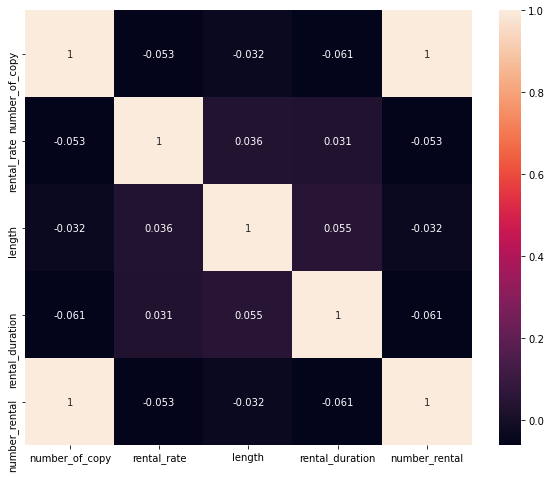

In [99]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

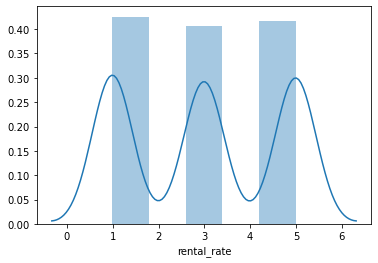

In [100]:
sns.distplot(data['rental_rate'])
plt.show()

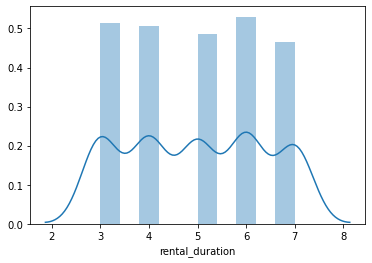

In [101]:
sns.distplot(data['rental_duration'])
plt.show()

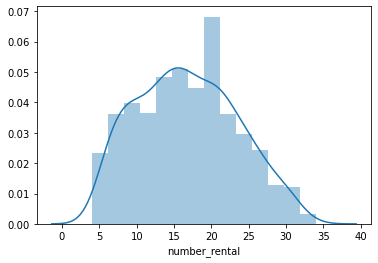

In [102]:
sns.distplot(data['number_rental'])
plt.show()

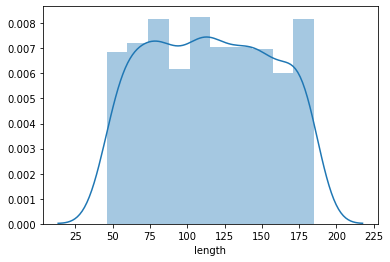

In [103]:
sns.distplot(data['length'])
plt.show()

In [104]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = data.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

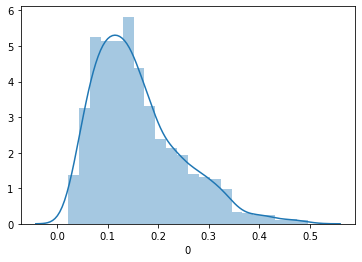

In [105]:
sns.distplot(x[0])
plt.show()

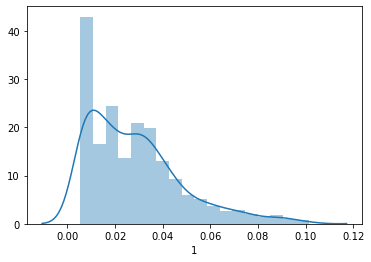

In [106]:
sns.distplot(x[1])
plt.show()

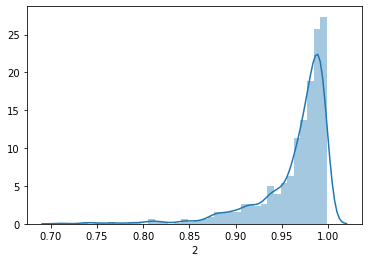

In [107]:
sns.distplot(x[2])
plt.show()

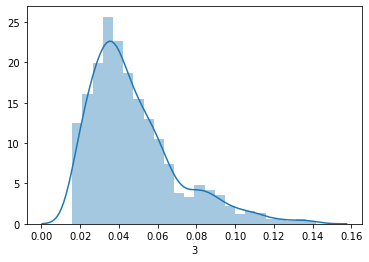

In [108]:
sns.distplot(x[3])
plt.show()

In [109]:
data.dtypes

film_id             object
category_name       object
number_of_copy       int64
rental_rate        float64
length               int64
rental_duration      int64
number_rental        int64
dtype: object

In [110]:
cat = data.select_dtypes(include = np.object)
cat = cat.drop(['film_id'], axis=1)
categorical = pd.get_dummies(cat, columns=['category_name'], drop_first=True)

In [ ]:
categorical.head()

4. Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [111]:
query = 'SELECT film.film_id, \
case \
    when count(rental.rental_id) > 0 then "1" \
    else "0" \
end as "Rented this month" \
FROM sakila.rental, inventory, film \
where rental_date >= 20050515 and rental_date <= 20050615 \
and rental.inventory_id=inventory.inventory_id \
and inventory.film_id=film.film_id \
group by film_id \
order by film_id'
data2 = pd.read_sql_query(query, engine)
data2.head()

,film_id,Rented this month
0,1,1
1,3,1
2,4,1
3,5,1
4,6,1


In [112]:
data2['Rented this month'].value_counts()

1    689
Name: Rented this month, dtype: int64

In [113]:
query  = 'select i.film_id  , count(r.rental_id) as Total_films_rented  \
from rental r  \
left join inventory i on r.inventory_id = i.inventory_id \
where rental_date >= 20050515 and rental_date <= 20050615 \
group by 1 \
order by 2'
data3 = pd.read_sql_query(query, engine)
data3.head()

,film_id,Total_films_rented
0,80,1
1,565,1
2,499,1
3,593,1
4,721,1


In [114]:
data3['Total_films_rented'].value_counts()

1    356
2    220
3     80
4     29
5      4
Name: Total_films_rented, dtype: int64

In [115]:
query3="""select f.film_id, count(r.rental_id) as "Last month rentals" from sakila.film as f
left join sakila.inventory as i
on f.film_id=i.film_id
left outer join sakila.rental as r
on i.inventory_id=r.inventory_id and (r.rental_date >= '2005-05-15') and (r.rental_date <= '2005-05-30')
group by f.film_id
order by f.film_id"""
df3 = pd.read_sql_query(query3, engine)
df3.head()

,film_id,Last month rentals
0,1,1
1,2,0
2,3,0
3,4,1
4,5,1


In [116]:
for i in range(len(df3)):
    if df3.loc[i, "Last month rentals"]>0:
        df3.loc[i, "Last month rentals"]='Yes'
    else:
        df3.loc[i, "Last month rentals"]='No'

In [117]:
df3['Last month rentals'].value_counts()

Yes    565
No     435
Name: Last month rentals, dtype: int64

In [122]:
data1 = pd.concat([data,df3],join = 'inner',axis =1)
data1

,film_id,category_name,number_of_copy,rental_rate,length,rental_duration,number_rental,film_id,Last month rentals
0,1,Documentary,24,0.99,86,6,24,1,Yes
1,2,Horror,7,4.99,48,3,7,2,No
2,3,Documentary,12,2.99,50,7,12,3,No
3,4,Horror,23,2.99,117,5,23,4,Yes
4,5,Family,12,2.99,130,6,12,5,Yes
...,...,...,...,...,...,...,...,...,...
953,996,Documentary,7,0.99,183,6,7,954,No
954,997,Music,6,0.99,179,4,6,955,No
955,998,Horror,9,0.99,105,6,9,956,Yes
956,999,Children,17,2.99,101,5,17,957,No


In [123]:
data1.corr()

,number_of_copy,rental_rate,length,rental_duration,number_rental,film_id
number_of_copy,1.000000,-0.053431,-0.032344,-0.060958,1.000000,-0.013193
rental_rate,-0.053431,1.000000,0.036295,0.030557,-0.053431,-0.031220
length,-0.032344,0.036295,1.000000,0.054995,-0.032344,0.051231
rental_duration,-0.060958,0.030557,0.054995,1.000000,-0.060958,-0.037793
number_rental,1.000000,-0.053431,-0.032344,-0.060958,1.000000,-0.013193
film_id,-0.013193,-0.031220,0.051231,-0.037793,-0.013193,1.000000


In [ ]:
# drop number_of_copy because it's the  same as number rental ?
# drop film_id

In [127]:
data1 = data1.drop(columns=['film_id', 'number_rental'])

In [128]:
data1.head()

,category_name,number_of_copy,rental_rate,length,rental_duration,Last month rentals
0,Documentary,24,0.99,86,6,Yes
1,Horror,7,4.99,48,3,No
2,Documentary,12,2.99,50,7,No
3,Horror,23,2.99,117,5,Yes
4,Family,12,2.99,130,6,Yes


5. Create a logistic regression model to predict this variable from the cleaned data.

In [131]:
from sklearn.preprocessing import Normalizer
# from sklearn.preprocessing import StandardScaler
import numpy as np
X = data1.select_dtypes(include = np.number)

# Normalizing data
transformer = Normalizer().fit(X)
x_normalized = transformer.transform(X)
x = pd.DataFrame(x_normalized)

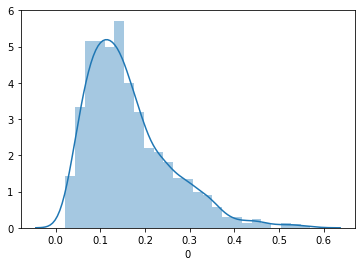

In [132]:
sns.distplot(x[0])
plt.show()

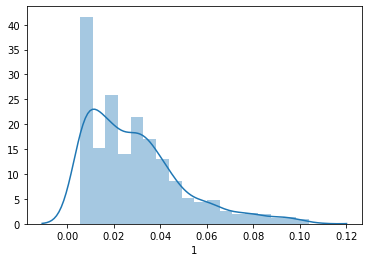

In [133]:
sns.distplot(x[1])
plt.show()

In [134]:
y = data1['Last month rentals']
X = np.concatenate((x, categorical), axis=1)

In [135]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [136]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [139]:
predictions = classification.predict(X_test)
print("The accuracy of the model is: %4.2f" % (classification.score(X_test, y_test)))

The accuracy of the model is: 0.53


In [140]:
pd.Series(predictions).value_counts()

Yes    360
No      24
dtype: int64

In [141]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
confusion_matrix(y_test, predictions)

array([[  7, 163],
       [ 17, 197]])

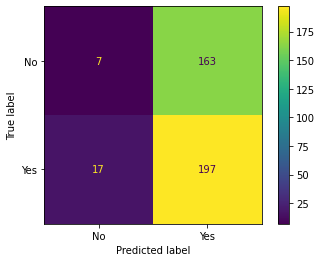

In [142]:
plot_confusion_matrix(classification, X_test, y_test) 

In [145]:
# Standardizer
from sklearn.preprocessing import StandardScaler
X2 = data1.select_dtypes(include = np.number)

transformer = StandardScaler().fit(X2)
x_standarized = transformer.transform(X2)
x_standarized = pd.DataFrame(x_standarized)

In [146]:
y = data1['Last month rentals']
X = np.concatenate((x_standarized, categorical), axis=1)

In [148]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)

In [149]:
from sklearn.linear_model import LogisticRegression
classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='multinomial').fit(X_train, y_train)

In [150]:
predictions = classification.predict(X_test)
print("The accuracy of the model is: %4.2f" % (classification.score(X_test, y_test)))

The accuracy of the model is: 0.53


6. Evaluate the results.